# Enhanced autoencoder model for similarity

In [1]:
!pip install umap-learn
from IPython.display import display
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.mixture import GaussianMixture
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from umap import UMAP
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Montage du drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.5 MB/s eta 0:00:00
Mounted at /content/drive


## 1. Image preprocessing

In [2]:
# Prétraitement des images
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image)

# Dataset non supervisé
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = preprocess_image(item['image_path'])
        return image

## 2. Enhanced autoencoder definition

In [3]:
# Autoencodeur amélioré
class EnhancedConvAutoencoder(nn.Module):
    def __init__(self):
        super(EnhancedConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        batch_size = x.size(0)
        # The output of the encoder has 64 channels, not 256
        spatial_dim = int(np.sqrt(x.numel() / (batch_size * 64)))
        # Reshape with 64 channels
        x = x.view(batch_size, 64, spatial_dim, spatial_dim)
        x = self.decoder(x)
        return x

## 3. Training loss function

In [4]:
# Fonction d'entraînement avec perte contrastive
def train_autoencoder_with_contrastive_loss(model, dataloader, optimizer, device, epochs=50):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images in dataloader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            embeddings = model.encoder(images).view(images.size(0), -1)  # Embeddings
            # Perte de reconstruction
            mse_loss = nn.MSELoss()(outputs, images)
            # Perte contrastive
            distances = torch.cdist(embeddings, embeddings, p=2)
            similar_loss = torch.mean(distances[distances < 1.0] ** 2)
            dissimilar_loss = torch.mean((1.0 - distances[distances >= 1.0]).clamp(min=0) ** 2)
            contrastive_loss = similar_loss + dissimilar_loss
            loss = mse_loss + contrastive_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

## 4. Embeddings

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Loss: 0.6268
Epoch [2/10], Loss: 0.4267
Epoch [3/10], Loss: 0.3414
Epoch [4/10], Loss: 0.3176
Epoch [5/10], Loss: 0.3201
Epoch [6/10], Loss: 0.3246
Epoch [7/10], Loss: 0.2903
Epoch [8/10], Loss: 0.2992
Epoch [9/10], Loss: 0.2640
Epoch [10/10], Loss: 0.2682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


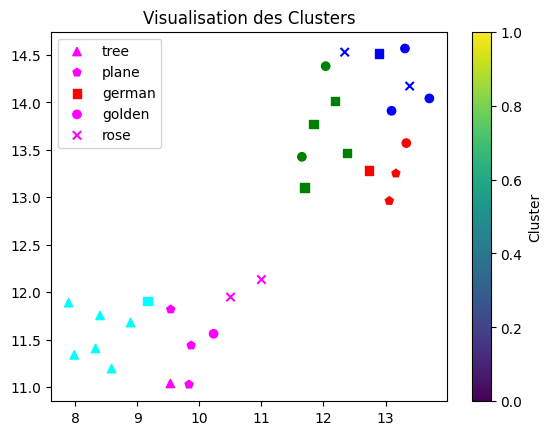

In [22]:
# Récupération des embeddings
def get_embeddings(data_loader, model, device):
    embeddings = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            embedding = model.encoder(images).view(images.size(0), -1).cpu().numpy()
            embeddings.append(embedding)
    return np.vstack(embeddings)

# Visualisation des embeddings
def visualize_embeddings(embeddings, cluster_labels, image_paths):
    # Define markers for different image groups
    group_markers = {
        "golden": "o",  # Circle for golden retrievers
        "german": "s",  # Square for german sheperds
        "tree": "^" , # Triangle for trees
        "plane": "p",
        "rose": "x"
    }
    # Define colors for different clusters
    cluster_colors = ['blue', 'cyan', 'green',"red","magenta"]

    # Extract group labels from image paths
    group_labels = [
        "golden" if "golden" in path else "german" if "german" in path else "tree" if "tree" in path else "plane" if "plane" in path else "rose" if "rose" in path else None
        for path in image_paths
    ]

    # Create a scatter plot with colors and markers
    fig, ax = plt.subplots()

    # Create separate scatter plots for each group with labels
    for group in set(group_labels):
        indices = [i for i, label in enumerate(group_labels) if label == group]
        scatter = ax.scatter(
            embeddings[indices, 0],
            embeddings[indices, 1],
            c=[cluster_colors[cluster_labels[i]] for i in indices],
            marker=group_markers[group],
            label=group
        )

    # Add legend for image groups
    ax.legend()
    plt.colorbar(scatter, label="Cluster")  # Pass the scatter plot object to colorbar
    plt.title("Visualisation des Clusters")
    plt.show()

# Données
example_data = [
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/golden.jpeg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/golden2.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/golden3.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/golden4.jpeg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/golden5.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/golden6.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/golden7.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/german1.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/german2.jpeg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/german3.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/german4.jpeg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/german5.png"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/german6.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/german7.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/tree.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/tree2.jpeg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/tree3.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/tree4.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/tree5.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/tree6.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/tree7.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/plane1.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/plane2.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/plane3.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/plane5.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/plane6.jfif"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/rose1.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/rose2.jpg"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/rose3.webp"},
    {"image_path": "/content/drive/My Drive/Colab Notebooks/Projet 3A/6. Unsupervised method/image/rose4.webp"}
]

unsupervised_dataset = UnsupervisedDataset(example_data)
dataloader = DataLoader(unsupervised_dataset, batch_size=4, shuffle=True)

# Configuration du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = EnhancedConvAutoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

# Entraînement
train_autoencoder_with_contrastive_loss(autoencoder, dataloader, optimizer, device, epochs=10)

# Extraction des embeddings
data_loader = DataLoader(unsupervised_dataset, batch_size=1, shuffle=False)
embeddings = get_embeddings(data_loader, autoencoder, device)

# Réduction avec UMAP
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)
umap = UMAP(n_components=2, n_neighbors=10, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap.fit_transform(embeddings)

# Clustering avec KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

# Visualisation des clusters KMeans
visualize_embeddings(reduced_embeddings, cluster_labels, [d['image_path'] for d in example_data])

## Test of the model on the mnist dataset

Training the Autoencoder in an Unsupervised Manner...
Epoch [1/4], Loss: 0.8748
Epoch [2/4], Loss: 0.8454
Epoch [3/4], Loss: 0.8449
Epoch [4/4], Loss: 0.8447
Extracting Embeddings...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Visualizing Clusters...


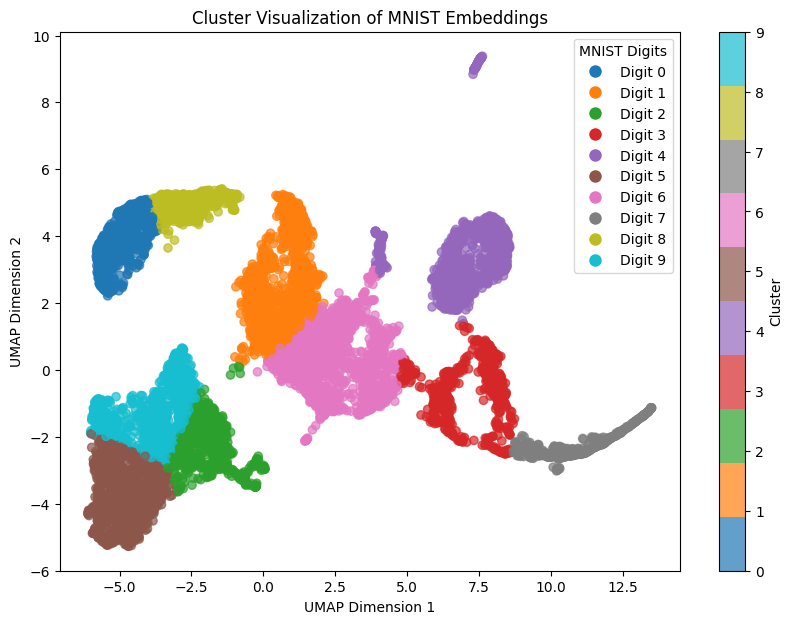

In [ ]:
# Load MNIST dataset (without using labels in training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoader without using labels
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Autoencoder for unsupervised learning
class MNISTAutoencoder(nn.Module):
    def __init__(self):
        super(MNISTAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        batch_size = x.size(0)
        encoded = encoded.view(batch_size, 64, 7, 7)  # Reshape to match decoder input
        decoded = self.decoder(encoded)
        return decoded

# Training function (unsupervised, no labels used)
def train_autoencoder(model, dataloader, optimizer, device, epochs=4):
    model.to(device)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in dataloader:  # Ignore labels
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)  # Unsupervised: compare reconstruction only
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

# Function to extract embeddings
def get_embeddings(data_loader, model, device):
    embeddings, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:  # Targets not used in unsupervised learning
            images = images.to(device)
            encoded = model.encoder(images).view(images.size(0), -1).cpu().numpy()
            embeddings.append(encoded)
            labels.extend(targets.numpy())  # Collect labels only for visualization
    return np.vstack(embeddings), np.array(labels)

# Visualization function for clusters
def visualize_clusters(embeddings, cluster_labels, labels):
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label="Cluster")
    plt.title("Cluster Visualization of MNIST Embeddings")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")

    # Add legend to indicate the actual digit classes (for visualization only)
    legend_labels = {i: f"Digit {i}" for i in range(10)}
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(i/10), markersize=10) for i in range(10)]
    plt.legend(handles, legend_labels.values(), title="MNIST Digits")
    plt.show()

# Train the autoencoder (unsupervised)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = MNISTAutoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

print("Training the Autoencoder in an Unsupervised Manner...")
train_autoencoder(autoencoder, train_loader, optimizer, device)

# Extract embeddings
print("Extracting Embeddings...")
embeddings, labels = get_embeddings(test_loader, autoencoder, device)

# Dimensionality reduction using UMAP
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
reduced_embeddings = umap.fit_transform(embeddings_scaled)

# Perform clustering with KMeans (10 clusters for digits 0-9)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_embeddings)

# Visualize clusters
print("Visualizing Clusters...")
visualize_clusters(reduced_embeddings, cluster_labels, labels)